# Projet 6

In [8]:
import random
import os
# notre package de fonctionnalités
from Package import Scripts_Analyse01 as pk
from Package import Scripts_AnalyseMulti01 as pk_multi

import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from umap import UMAP
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.features import ParallelCoordinates
from plotly.graph_objects import Layout
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import PCA as PCA_yellow
from yellowbrick.style import set_palette
from sklearn import metrics
import gc
import time
from contextlib import contextmanager
import warnings
import numpy as np
from datetime import datetime
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from dotenv import load_dotenv
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
import spacy
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext pycodestyle_magic

In [6]:
%flake8_off

UsageError: Line magic function `%flake8_off` not found.


In [9]:
# chargement des variables d'environnment
load_dotenv() 

Python-dotenv could not parse statement starting at line 1


True

# Collecte des données

Uniquement API ? Les fichiers json ?

In [38]:
api_key = os.getenv('API_KEY')
endpoint = "https://api.yelp.com/v3/graphql"

Réalisons une fonction pour réaliser des requêtes en GraphQL. On utilise cette solution afin de pouvoir collecter les informations uniquement des champs qui nous intéressent.

In [39]:
def request_client(api_key, endpoint, query):
    reqHeaders = {
        'Authorization': 'Bearer ' + api_key 
    }

    _transport = RequestsHTTPTransport(
        url=endpoint,
        headers = reqHeaders,
        use_json=True,
    )

    client = Client(
        transport = _transport,
        fetch_schema_from_transport=True,
    )

    result = client.execute(query)
    return result

In [99]:
# le max de review est de 3 par restaurant, on importe toutes les données
restaurants=[]
j = 0
for i in range(0,4):
    query = """
                {
                search(term:"restaurant",
                        location:"FR"
                        limit:50,
                        offset:"""+str(j)+"""
                        ) {
                    business {
                    id,
                    name,
                    photos,
                    reviews{
                        id,
                        text,
                        rating
                    }
                    }
                }
                }
            """
    query = gql(query)
    temp = request_client(api_key, endpoint, query)["search"]["business"]
    restaurants.extend(temp)
    print("nb restaurants ", len(restaurants))
    j=j+51
    

nb restaurants  50
nb restaurants  100
nb restaurants  150
nb restaurants  200


In [100]:
restaurants = pd.DataFrame(restaurants)

In [101]:
restaurants.head(2)

,id,name,photos,reviews
0,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,[https://s3-media2.fl.yelpcdn.com/bphoto/TtMQl...,"[{'id': 'aGP7nLwEQOUg64jKP8ebsw', 'text': 'My ..."
1,IU9_wVOGBKjfqTTpAXpKcQ,Bistro des Augustins,[https://s3-media4.fl.yelpcdn.com/bphoto/J9RBy...,"[{'id': '-to6adg_kucf1SgQckgJXw', 'text': 'Thi..."


Nous exportons les données au format csv pour les sauvegarder

In [102]:
restaurants.to_csv('output/restaurants.csv')

In [103]:
# restaurants = pd.read_csv('./output/restaurants.csv')
# del df["Unnamed: 0"]
# df.columns = ["id", "name", "photos", "reviews"]

# Construction des bases de données

On scinde notre fichier en deux afin de traiter le texte et les photos séparément.

In [104]:
df = restaurants.copy()

In [105]:
df.head(2)

,id,name,photos,reviews
0,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,[https://s3-media2.fl.yelpcdn.com/bphoto/TtMQl...,"[{'id': 'aGP7nLwEQOUg64jKP8ebsw', 'text': 'My ..."
1,IU9_wVOGBKjfqTTpAXpKcQ,Bistro des Augustins,[https://s3-media4.fl.yelpcdn.com/bphoto/J9RBy...,"[{'id': '-to6adg_kucf1SgQckgJXw', 'text': 'Thi..."


In [106]:
df['reviews'].apply(pd.Series)[0].apply(pd.Series)

,0,id,rating,text
0,NaN,aGP7nLwEQOUg64jKP8ebsw,5.0,My favorite meal in Paris! \n\nWe started off ...
1,NaN,-to6adg_kucf1SgQckgJXw,5.0,This is a small bar/restaurant closed to Cathé...
2,NaN,U8G3f8ITSlqBzETBDVO8bw,5.0,"Foods were delicious, great ambiance, and help..."
3,NaN,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ..."
4,NaN,giErkj8Al6-egq5XUu2FqA,5.0,Michelin starred. Reservations weeks in advanc...
...,...,...,...,...
195,NaN,APBAlRXsEX0-B_lwYXFSzw,4.0,"Paris, France\n\nHangry? \n\nWhen the most pop..."
196,NaN,37Klq0mvBK1WkxnhI0HRCg,5.0,Stopped here for dinner on our first night in ...
197,NaN,K--hr3q7hJFXuFvZbQTM7Q,5.0,Everything on the menu seems to be fully maste...
198,NaN,dkkicroZxI_fOiPW4B_GZw,5.0,My husband and I wanted to try a coq au vin wh...


In [107]:
df

,id,name,photos,reviews
0,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,[https://s3-media2.fl.yelpcdn.com/bphoto/TtMQl...,"[{'id': 'aGP7nLwEQOUg64jKP8ebsw', 'text': 'My ..."
1,IU9_wVOGBKjfqTTpAXpKcQ,Bistro des Augustins,[https://s3-media4.fl.yelpcdn.com/bphoto/J9RBy...,"[{'id': '-to6adg_kucf1SgQckgJXw', 'text': 'Thi..."
2,KggnM_Z4wOa_JExunaaWHg,Le Temps des Cerises,[https://s3-media1.fl.yelpcdn.com/bphoto/g3Aab...,"[{'id': 'U8G3f8ITSlqBzETBDVO8bw', 'text': 'Foo..."
3,WHHt_Jb8Tgidn9mW7oDnIg,La Coïncidence,[https://s3-media1.fl.yelpcdn.com/bphoto/QdrAg...,"[{'id': 'WMRKQUUR3BmjV_EZg7zVfw', 'text': 'thi..."
4,_qACPRqSQ6Nvd20H8EY3uw,Frenchie Restaurant,[https://s3-media2.fl.yelpcdn.com/bphoto/E8EGl...,"[{'id': 'giErkj8Al6-egq5XUu2FqA', 'text': 'Mic..."
...,...,...,...,...
195,26YjCdVvyn5jv4sZYd1Lvw,Loup,[https://s3-media2.fl.yelpcdn.com/bphoto/M1pgS...,"[{'id': 'APBAlRXsEX0-B_lwYXFSzw', 'text': 'Par..."
196,MN-I5rJBYAZwp2jeHXs_JQ,L'Alsacien,[https://s3-media3.fl.yelpcdn.com/bphoto/Um1ia...,"[{'id': '37Klq0mvBK1WkxnhI0HRCg', 'text': 'Sto..."
197,fK5KhHO8az5LVmzOPsED2g,Miznon,[https://s3-media3.fl.yelpcdn.com/bphoto/q_AOt...,"[{'id': 'K--hr3q7hJFXuFvZbQTM7Q', 'text': 'Eve..."
198,R44YZMAdHQFB9BCIUcwnhA,Machon d'Henri Le,[https://s3-media1.fl.yelpcdn.com/bphoto/n6_5Y...,"[{'id': 'dkkicroZxI_fOiPW4B_GZw', 'text': 'My ..."


In [108]:
df = pd.concat([df.drop(['reviews'], axis=1), 
    df['reviews'].apply(pd.Series)[0].apply(pd.Series)]
    , axis=1)


In [109]:
df.columns

Index(['id', 'name', 'photos', 0, 'id', 'rating', 'text'], dtype='object')

In [110]:
df.columns = ['id', 'name', 'photos','pb', 'rw_id', 
          'rw_rating','rw_text']

In [111]:
del df["pb"]

Exportons les données en csv

In [112]:
df.to_csv('output/restaurants_v2.csv')

In [10]:
df = pd.read_csv('output/restaurants_v2.csv')

In [4]:
df
#del df["Unnamed: 0"]

,Unnamed: 0,id,name,photos,rw_id,rw_rating,rw_text
0,0,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,['https://s3-media2.fl.yelpcdn.com/bphoto/TtMQ...,aGP7nLwEQOUg64jKP8ebsw,5.0,My favorite meal in Paris! \n\nWe started off ...
1,1,IU9_wVOGBKjfqTTpAXpKcQ,Bistro des Augustins,['https://s3-media4.fl.yelpcdn.com/bphoto/J9RB...,-to6adg_kucf1SgQckgJXw,5.0,This is a small bar/restaurant closed to Cathé...
2,2,KggnM_Z4wOa_JExunaaWHg,Le Temps des Cerises,['https://s3-media1.fl.yelpcdn.com/bphoto/g3Aa...,U8G3f8ITSlqBzETBDVO8bw,5.0,"Foods were delicious, great ambiance, and help..."
3,3,WHHt_Jb8Tgidn9mW7oDnIg,La Coïncidence,['https://s3-media1.fl.yelpcdn.com/bphoto/QdrA...,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ..."
4,4,_qACPRqSQ6Nvd20H8EY3uw,Frenchie Restaurant,['https://s3-media2.fl.yelpcdn.com/bphoto/E8EG...,giErkj8Al6-egq5XUu2FqA,5.0,Michelin starred. Reservations weeks in advanc...
...,...,...,...,...,...,...,...
195,195,26YjCdVvyn5jv4sZYd1Lvw,Loup,['https://s3-media2.fl.yelpcdn.com/bphoto/M1pg...,APBAlRXsEX0-B_lwYXFSzw,4.0,"Paris, France\n\nHangry? \n\nWhen the most pop..."
196,196,MN-I5rJBYAZwp2jeHXs_JQ,L'Alsacien,['https://s3-media3.fl.yelpcdn.com/bphoto/Um1i...,37Klq0mvBK1WkxnhI0HRCg,5.0,Stopped here for dinner on our first night in ...
197,197,fK5KhHO8az5LVmzOPsED2g,Miznon,['https://s3-media3.fl.yelpcdn.com/bphoto/q_AO...,K--hr3q7hJFXuFvZbQTM7Q,5.0,Everything on the menu seems to be fully maste...
198,198,R44YZMAdHQFB9BCIUcwnhA,Machon d'Henri Le,['https://s3-media1.fl.yelpcdn.com/bphoto/n6_5...,dkkicroZxI_fOiPW4B_GZw,5.0,My husband and I wanted to try a coq au vin wh...


In [11]:
reviews = df[["rw_id", "rw_rating", "rw_text"]].copy()

In [12]:
reviews["rw_rating"].unique()

array([ 5.,  4., nan,  3.,  1.])

In [13]:
photos = df[["id", "photos"]]

# Analyse des données

## Pré traitement des données textuelles

Analysons le texte en premier lieu

In [14]:
from collections import defaultdict

tokenizer = nltk.RegexpTokenizer(r'\w+')
tokenizer.tokenize("This is a small bar/restaurant closed to Cathédrale Notre Dame. I always come here for lunch or dinner if I am close by. The hostess is very friendly. The...")
tokenizer = nltk.RegexpTokenizer(r'\w+')


Le but est de découvrir les sujets insatisfaisants, nous commençons par compter le nombre de mots.

In [15]:
reviews

,rw_id,rw_rating,rw_text
0,aGP7nLwEQOUg64jKP8ebsw,5.0,My favorite meal in Paris! \n\nWe started off ...
1,-to6adg_kucf1SgQckgJXw,5.0,This is a small bar/restaurant closed to Cathé...
2,U8G3f8ITSlqBzETBDVO8bw,5.0,"Foods were delicious, great ambiance, and help..."
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ..."
4,giErkj8Al6-egq5XUu2FqA,5.0,Michelin starred. Reservations weeks in advanc...
...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,"Paris, France\n\nHangry? \n\nWhen the most pop..."
196,37Klq0mvBK1WkxnhI0HRCg,5.0,Stopped here for dinner on our first night in ...
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,Everything on the menu seems to be fully maste...
198,dkkicroZxI_fOiPW4B_GZw,5.0,My husband and I wanted to try a coq au vin wh...


In [10]:
reviews["rw_text"]

0      My favorite meal in Paris! \n\nWe started off ...
1      This is a small bar/restaurant closed to Cathé...
2      Foods were delicious, great ambiance, and help...
3      this is for a review from 2019, this place is ...
4      Michelin starred. Reservations weeks in advanc...
                             ...                        
195    Paris, France\n\nHangry? \n\nWhen the most pop...
196    Stopped here for dinner on our first night in ...
197    Everything on the menu seems to be fully maste...
198    My husband and I wanted to try a coq au vin wh...
199    Hard to find a nice French restaurant without ...
Name: rw_text, Length: 200, dtype: object

In [16]:
reviews["rw_text"] = reviews["rw_text"].fillna("")
reviews["rw_rating"] = reviews["rw_rating"].fillna(np.mean)

In [17]:
reviews["rw_text"] = reviews["rw_text"].str.lower()
for index, element in reviews.iterrows():
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    print(element["rw_text"])
    tokens = tokenizer.tokenize(element["rw_text"])
    reviews.loc[index, "nb_words"] = len(tokens)
    reviews.loc[index, "words"] = str(tokens)

my favorite meal in paris! 

we started off with the foie gras carpaccio and escargot. love the unique way that the foie gras was prepared and so thinly...
this is a small bar/restaurant closed to cathédrale notre dame. i always come here for lunch or dinner if i am close by. the hostess is very friendly. the...
foods were delicious, great ambiance, and helpful staffs. 
the risotto cooked perfectly! i got the white fish with house white sauce (tasta like fennel,...
this is for a review from 2019, this place is perfect. would recommend 100%. prices are great, food is astounding.

and i never leave reviews.
michelin starred. reservations weeks in advance is absolutely necessary to dine at an establishment like this. my second time here. very sophisticated vibe...
when i visited paris last week, i had stopped by here by a recommendation of a friend and also recommended by bourdain! this place was amazing and lives up...
based on some research, we decided to book a reservation here for a m

In [13]:
reviews

,rw_id,rw_rating,rw_text,nb_words,words
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'..."
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran..."
2,U8G3f8ITSlqBzETBDVO8bw,5.0,"foods were delicious, great ambiance, and help...",24.0,"['foods', 'were', 'delicious', 'great', 'ambia..."
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ...",25.0,"['this', 'is', 'for', 'a', 'review', 'from', '..."
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred. reservations weeks in advanc...,23.0,"['michelin', 'starred', 'reservations', 'weeks..."
...,...,...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,"paris, france\n\nhangry? \n\nwhen the most pop...",27.0,"['paris', 'france', 'hangry', 'when', 'the', '..."
196,37Klq0mvBK1WkxnhI0HRCg,5.0,stopped here for dinner on our first night in ...,29.0,"['stopped', 'here', 'for', 'dinner', 'on', 'ou..."
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,everything on the menu seems to be fully maste...,29.0,"['everything', 'on', 'the', 'menu', 'seems', '..."
198,dkkicroZxI_fOiPW4B_GZw,5.0,my husband and i wanted to try a coq au vin wh...,34.0,"['my', 'husband', 'and', 'i', 'wanted', 'to', ..."


In [14]:
graph = reviews.sort_values(by='nb_words', ascending=False)
pk.graph_intv_bar(graph, 'rw_id', 'nb_words', "rw_id", "nb words", 'redor', "Nombre de mots par commentaire")

Regardons les mots les plus fréquents

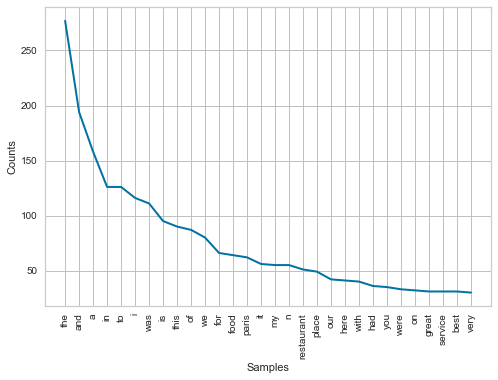

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [18]:
word_mostfreq = str(list(reviews["rw_text"]))
fdist = nltk.FreqDist(tokenizer.tokenize(word_mostfreq))
fdist.plot(30)

Réalisons une fonction.

In [19]:
def nb_most_frequent_plt(df_var):
    word_mostfreq = str(list(df_var))
    fdist = nltk.FreqDist(tokenizer.tokenize(word_mostfreq))
    fdist.plot(30)

Nous observons des mots communs comme "the" qui ne seront pas utiles.

In [20]:
gc.collect()

26854

In [21]:
from nltk.corpus import stopwords
nltk.download('stopwords')

sw_nltk = stopwords.words('english')
print(sw_nltk)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dans la liste stopwords du package, il y a des mots qui sont importants pour l'identification des sentiments comme "very" ou les négations ("not"...)
Supprimons ces éléments de la liste de stopwords.

In [22]:
keep_words = ["you're", "you've", "you'll", "you'd", 
"she's", "it's", "that'll", 'is', 'are', 
  'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 
  'doing', 'on', 'off', 'again', 'further', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'than', 
    'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've",
     'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',
      "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', 
      "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 
      'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
new_sw_nltk = [word for word in sw_nltk if word not in keep_words]

In [116]:
new_sw_nltk.append("paris")
new_sw_nltk.extend(['10pm',
 '11th',
 '15pm',
 '1920s',
 '1er',
 '1rst',
 '1st',
 '4th',
 '5th',
 '7pm',
 '9th'])

Ces mots n'apportent pas de sens concernant les sentiments dans les phrases. Autrement dit, ce sont des mots dit vides pour notre projet.

In [24]:
reviews

,rw_id,rw_rating,rw_text,nb_words,words
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'..."
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran..."
2,U8G3f8ITSlqBzETBDVO8bw,5.0,"foods were delicious, great ambiance, and help...",24.0,"['foods', 'were', 'delicious', 'great', 'ambia..."
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ...",25.0,"['this', 'is', 'for', 'a', 'review', 'from', '..."
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred. reservations weeks in advanc...,23.0,"['michelin', 'starred', 'reservations', 'weeks..."
...,...,...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,"paris, france\n\nhangry? \n\nwhen the most pop...",27.0,"['paris', 'france', 'hangry', 'when', 'the', '..."
196,37Klq0mvBK1WkxnhI0HRCg,5.0,stopped here for dinner on our first night in ...,29.0,"['stopped', 'here', 'for', 'dinner', 'on', 'ou..."
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,everything on the menu seems to be fully maste...,29.0,"['everything', 'on', 'the', 'menu', 'seems', '..."
198,dkkicroZxI_fOiPW4B_GZw,5.0,my husband and i wanted to try a coq au vin wh...,34.0,"['my', 'husband', 'and', 'i', 'wanted', 'to', ..."


In [117]:
pat = r'\b(?:{})\b'.format('|'.join(new_sw_nltk))
reviews['new_words'] = reviews['words'].str.replace(pat, '')



In [118]:
reviews

,rw_id,rw_rating,rw_text,nb_words,words,new_words,stemmed,words_ok,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,feeling_pos,feeling_avg,card2vec,use,tsnec2v,tsneuse,tfidf,tsnetfidf
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","['', 'favorite', 'meal', '', '', '', 'started'...","[""''""'favorit''meal'""''""""''""""''""'start''off'""'...",favorit meal start off foie gras carpaccio esc...,"[(favorit, NN), (meal, JJ), (start, VB), (off,...","favorit meal meal,foie gras gras,prepar prepar",0.000,0.781,0.219,Positive,"[-0.0007876556483097374, -0.01030307449400425,...","[0.043498240411281586, -0.022697744891047478, ...","[-8.100602149963379, -14.270103454589844]","[3.4278781414031982, 6.080378532409668]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.059324264526367, -26.21450424194336]"
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran...","['', 'is', '', 'small', 'bar', 'restaurant', '...","[""''""'is'""''""'small''bar''restaur''close'""''""'...",is small bar restaur close cathédral notr dame...,"[(is, VBZ), (small, JJ), (bar, NN), (restaur, ...","small bar restaur restaur,cathédral notr dame ...",0.000,0.833,0.167,Positive,"[-0.010225021280348301, -0.026473214849829674,...","[-0.006249221973121166, -0.03621714934706688, ...","[-0.19425524771213531, 1.337959885597229]","[-2.509223461151123, -1.199243426322937]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.39487648010254, 5.819638729095459]"
2,U8G3f8ITSlqBzETBDVO8bw,5.0,"foods were delicious, great ambiance, and help...",24.0,"['foods', 'were', 'delicious', 'great', 'ambia...","['foods', 'were', 'delicious', 'great', 'ambia...","[""''food""'were''delici''great''ambianc'""''""'he...",food were delici great ambianc help staff riso...,"[(food, NN), (were, VBD), (delici, JJ), (great...","food food,delici great ambianc help staff staf...",0.000,0.536,0.464,Positive,"[0.0006642180378548801, -0.027811536565423012,...","[-0.02060977928340435, 0.028547946363687515, -...","[-4.216114521026611, -7.174286365509033]","[-2.81744647026062, 2.735243558883667]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.19718468189239502, -11.616109848022461]"
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ...",25.0,"['this', 'is', 'for', 'a', 'review', 'from', '...","['', 'is', '', '', 'review', '', '2019', '', '...","[""''""'is'""''""""''""'review'""''""'2019'""''""'place'...",is review place is perfect would recommend pri...,"[(is, VBZ), (review, JJ), (place, NN), (is, VB...","review place place,price price,great food food...",0.000,0.480,0.520,Positive,"[-0.0013485390227288008, -0.018679412081837654...","[-0.05699789151549339, 0.03655901551246643, 0....","[-3.9263033866882324, -8.255666732788086]","[-6.362226963043213, 0.960125744342804]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.79364538192749, 10.077446937561035]"
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred. reservations weeks in advanc...,23.0,"['michelin', 'starred', 'reservations', 'weeks...","['michelin', 'starred', 'reservations', 'weeks...","[""''michelin""'star''reserv''week'""''""'advanc''...",michelin star reserv week advanc is absolut ne...,"[(michelin, NN), (star, NN), (reserv, NN), (we...","michelin star reserv week advanc advanc,second...",0.000,0.857,0.143,Positive,"[-0.006408204790204763, -0.01970580965280533, ...","[0.02894892543554306, -0.12255124747753143, 0....","[-2.754542589187622, -4.016138553619385]","[-6.864340782165527, -8.521047592163086]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[13.93277359008789, -27.676841735839844]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,"paris, france\n\nhangry? \n\nwhen the most pop...",27.0,"['paris', 'france', 'hangry', 'when', 'the', '...","['', 'france', 

Etudions à nouveau les mots les plus fréquents.

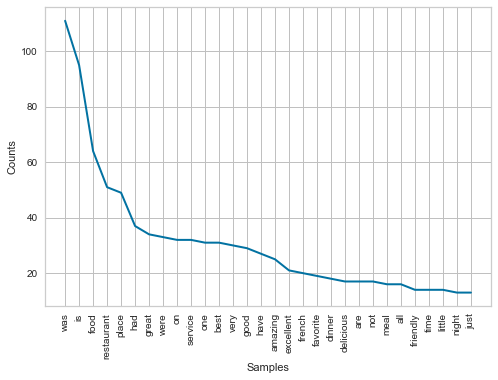

In [119]:
nb_most_frequent_plt(reviews["new_words"])

Nous n'avons plus de mots dit vides. Il nous faut à présent conserver la racine des mots et regarder les trigrammes pour conserver le sens des mots.

In [120]:
reviews

,rw_id,rw_rating,rw_text,nb_words,words,new_words,stemmed,words_ok,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,feeling_pos,feeling_avg,card2vec,use,tsnec2v,tsneuse,tfidf,tsnetfidf
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","['', 'favorite', 'meal', '', '', '', 'started'...","[""''""'favorit''meal'""''""""''""""''""'start''off'""'...",favorit meal start off foie gras carpaccio esc...,"[(favorit, NN), (meal, JJ), (start, VB), (off,...","favorit meal meal,foie gras gras,prepar prepar",0.000,0.781,0.219,Positive,"[-0.0007876556483097374, -0.01030307449400425,...","[0.043498240411281586, -0.022697744891047478, ...","[-8.100602149963379, -14.270103454589844]","[3.4278781414031982, 6.080378532409668]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.059324264526367, -26.21450424194336]"
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran...","['', 'is', '', 'small', 'bar', 'restaurant', '...","[""''""'is'""''""'small''bar''restaur''close'""''""'...",is small bar restaur close cathédral notr dame...,"[(is, VBZ), (small, JJ), (bar, NN), (restaur, ...","small bar restaur restaur,cathédral notr dame ...",0.000,0.833,0.167,Positive,"[-0.010225021280348301, -0.026473214849829674,...","[-0.006249221973121166, -0.03621714934706688, ...","[-0.19425524771213531, 1.337959885597229]","[-2.509223461151123, -1.199243426322937]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.39487648010254, 5.819638729095459]"
2,U8G3f8ITSlqBzETBDVO8bw,5.0,"foods were delicious, great ambiance, and help...",24.0,"['foods', 'were', 'delicious', 'great', 'ambia...","['foods', 'were', 'delicious', 'great', 'ambia...","[""''food""'were''delici''great''ambianc'""''""'he...",food were delici great ambianc help staff riso...,"[(food, NN), (were, VBD), (delici, JJ), (great...","food food,delici great ambianc help staff staf...",0.000,0.536,0.464,Positive,"[0.0006642180378548801, -0.027811536565423012,...","[-0.02060977928340435, 0.028547946363687515, -...","[-4.216114521026611, -7.174286365509033]","[-2.81744647026062, 2.735243558883667]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.19718468189239502, -11.616109848022461]"
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ...",25.0,"['this', 'is', 'for', 'a', 'review', 'from', '...","['', 'is', '', '', 'review', '', '2019', '', '...","[""''""'is'""''""""''""'review'""''""'2019'""''""'place'...",is review place is perfect would recommend pri...,"[(is, VBZ), (review, JJ), (place, NN), (is, VB...","review place place,price price,great food food...",0.000,0.480,0.520,Positive,"[-0.0013485390227288008, -0.018679412081837654...","[-0.05699789151549339, 0.03655901551246643, 0....","[-3.9263033866882324, -8.255666732788086]","[-6.362226963043213, 0.960125744342804]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.79364538192749, 10.077446937561035]"
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred. reservations weeks in advanc...,23.0,"['michelin', 'starred', 'reservations', 'weeks...","['michelin', 'starred', 'reservations', 'weeks...","[""''michelin""'star''reserv''week'""''""'advanc''...",michelin star reserv week advanc is absolut ne...,"[(michelin, NN), (star, NN), (reserv, NN), (we...","michelin star reserv week advanc advanc,second...",0.000,0.857,0.143,Positive,"[-0.006408204790204763, -0.01970580965280533, ...","[0.02894892543554306, -0.12255124747753143, 0....","[-2.754542589187622, -4.016138553619385]","[-6.864340782165527, -8.521047592163086]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[13.93277359008789, -27.676841735839844]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,"paris, france\n\nhangry? \n\nwhen the most pop...",27.0,"['paris', 'france', 'hangry', 'when', 'the', '...","['', 'france', 

In [121]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')

reviews['stemmed'] = reviews['new_words'].apply(lambda x: [stemmer.stem(y).replace("['","''")  for y in list(x.split(", "))])

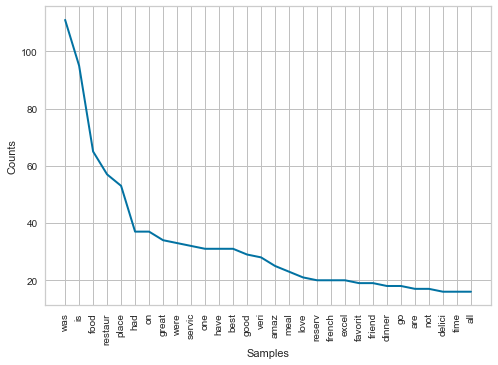

In [122]:
nb_most_frequent_plt(reviews["stemmed"])

Maintenant que nous avons que les racines des mots, réalisons les trigrammes

In [123]:
reviews["stemmed"] = reviews["stemmed"].apply(lambda x: "".join(str(x).split(", "))  )

In [124]:
reviews["stemmed"] 

0      ["''"'favorit''meal'"''""''""''"'start''off'"'...
1      ["''"'is'"''"'small''bar''restaur''close'"''"'...
2      ["''food"'were''delici''great''ambianc'"''"'he...
3      ["''"'is'"''""''"'review'"''"'2019'"''"'place'...
4      ["''michelin"'star''reserv''week'"''"'advanc''...
                             ...                        
195    ["''"'franc''hangri'"''""''"'most''popular''pl...
196    ["''stop""''""''"'dinner''on'"''"'first''night...
197    ["''everyth"'on'"''"'menu''seem'"''"'be''fulli...
198    ["''"'husband'"''""''"'want'"''"'tri'"''"'coq'...
199    ["''hard""''"'find'"''"'nice''french''restaur'...
Name: stemmed, Length: 200, dtype: object

In [125]:
reviews.head(2)

,rw_id,rw_rating,rw_text,nb_words,words,new_words,stemmed,words_ok,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,feeling_pos,feeling_avg,card2vec,use,tsnec2v,tsneuse,tfidf,tsnetfidf
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","['', 'favorite', 'meal', '', '', '', 'started'...","[""''""'favorit''meal'""''""""''""""''""'start''off'""'...",favorit meal start off foie gras carpaccio esc...,"[(favorit, NN), (meal, JJ), (start, VB), (off,...","favorit meal meal,foie gras gras,prepar prepar",0.0,0.781,0.219,Positive,"[-0.0007876556483097374, -0.01030307449400425,...","[0.043498240411281586, -0.022697744891047478, ...","[-8.100602149963379, -14.270103454589844]","[3.4278781414031982, 6.080378532409668]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.059324264526367, -26.21450424194336]"
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran...","['', 'is', '', 'small', 'bar', 'restaurant', '...","[""''""'is'""''""'small''bar''restaur''close'""''""'...",is small bar restaur close cathédral notr dame...,"[(is, VBZ), (small, JJ), (bar, NN), (restaur, ...","small bar restaur restaur,cathédral notr dame ...",0.0,0.833,0.167,Positive,"[-0.010225021280348301, -0.026473214849829674,...","[-0.006249221973121166, -0.03621714934706688, ...","[-0.19425524771213531, 1.337959885597229]","[-2.509223461151123, -1.199243426322937]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.39487648010254, 5.819638729095459]"


In [126]:
for index, element in reviews.iterrows():
    tokenizer = nltk.RegexpTokenizer(r'\w+[a-z]')
    tokens = tokenizer.tokenize(str(element["stemmed"]))
    reviews.loc[index, "words_ok"] = " ".join(tokens)
    # reviews.drop(["new_words", "stemmed"], axis=1)

In [127]:
reviews.head(5)

,rw_id,rw_rating,rw_text,nb_words,words,new_words,stemmed,words_ok,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,feeling_pos,feeling_avg,card2vec,use,tsnec2v,tsneuse,tfidf,tsnetfidf
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","['', 'favorite', 'meal', '', '', '', 'started'...","[""''""'favorit''meal'""''""""''""""''""'start''off'""'...",favorit meal start off foie gras carpaccio esc...,"[(favorit, NN), (meal, JJ), (start, VB), (off,...","favorit meal meal,foie gras gras,prepar prepar",0.0,0.781,0.219,Positive,"[-0.0007876556483097374, -0.01030307449400425,...","[0.043498240411281586, -0.022697744891047478, ...","[-8.100602149963379, -14.270103454589844]","[3.4278781414031982, 6.080378532409668]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.059324264526367, -26.21450424194336]"
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran...","['', 'is', '', 'small', 'bar', 'restaurant', '...","[""''""'is'""''""'small''bar''restaur''close'""''""'...",is small bar restaur close cathédral notr dame...,"[(is, VBZ), (small, JJ), (bar, NN), (restaur, ...","small bar restaur restaur,cathédral notr dame ...",0.0,0.833,0.167,Positive,"[-0.010225021280348301, -0.026473214849829674,...","[-0.006249221973121166, -0.03621714934706688, ...","[-0.19425524771213531, 1.337959885597229]","[-2.509223461151123, -1.199243426322937]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.39487648010254, 5.819638729095459]"
2,U8G3f8ITSlqBzETBDVO8bw,5.0,"foods were delicious, great ambiance, and help...",24.0,"['foods', 'were', 'delicious', 'great', 'ambia...","['foods', 'were', 'delicious', 'great', 'ambia...","[""''food""'were''delici''great''ambianc'""''""'he...",food were delici great ambianc help staff riso...,"[(food, NN), (were, VBD), (delici, JJ), (great...","food food,delici great ambianc help staff staf...",0.0,0.536,0.464,Positive,"[0.0006642180378548801, -0.027811536565423012,...","[-0.02060977928340435, 0.028547946363687515, -...","[-4.216114521026611, -7.174286365509033]","[-2.81744647026062, 2.735243558883667]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.19718468189239502, -11.616109848022461]"
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ...",25.0,"['this', 'is', 'for', 'a', 'review', 'from', '...","['', 'is', '', '', 'review', '', '2019', '', '...","[""''""'is'""''""""''""'review'""''""'2019'""''""'place'...",is review place is perfect would recommend pri...,"[(is, VBZ), (review, JJ), (place, NN), (is, VB...","review place place,price price,great food food...",0.0,0.480,0.520,Positive,"[-0.0013485390227288008, -0.018679412081837654...","[-0.05699789151549339, 0.03655901551246643, 0....","[-3.9263033866882324, -8.255666732788086]","[-6.362226963043213, 0.960125744342804]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.79364538192749, 10.077446937561035]"
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred. reservations weeks in advanc...,23.0,"['michelin', 'starred', 'reservations', 'weeks...","['michelin', 'starred', 'reservations', 'weeks...","[""''michelin""'star''reserv''week'""''""'advanc''...",michelin star reserv week advanc is absolut ne...,"[(michelin, NN), (star, NN), (reserv, NN), (we...","michelin star reserv week advanc advanc,second...",0.0,0.857,0.143,Positive,"[-0.006408204790204763, -0.01970580965280533, ...","[0.02894892543554306, -0.12255124747753143, 0....","[-2.754542589187622, -4.016138553619385]","[-6.864340782165527, -8.521047592163086]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[13.93277359008789, -27.676841735839844]"


In [128]:
trigrams_all= []
for element in reviews["words_ok"]:
    token = nltk.word_tokenize(element)
    trigrams = ngrams(token,3)
    trigrams_all.append(list(trigrams))
    break
trigrams_all

[[('favorit', 'meal', 'start'),
  ('meal', 'start', 'off'),
  ('start', 'off', 'foie'),
  ('off', 'foie', 'gras'),
  ('foie', 'gras', 'carpaccio'),
  ('gras', 'carpaccio', 'escargot'),
  ('carpaccio', 'escargot', 'love'),
  ('escargot', 'love', 'uniqu'),
  ('love', 'uniqu', 'way'),
  ('uniqu', 'way', 'foie'),
  ('way', 'foie', 'gras'),
  ('foie', 'gras', 'was'),
  ('gras', 'was', 'prepar'),
  ('was', 'prepar', 'thinly')]]

In [129]:
gc.collect()

278529

Ajoutons des tags pour connaitre la nature de chaque mot.

In [130]:
def word_pos_tagger(text):
    pos_tagged_text = nltk.pos_tag(text)
    return pos_tagged_text
nltk.download('averaged_perceptron_tagger')
reviews['text_tokens_pos_tagged'] = reviews["words_ok"].apply(lambda x: word_pos_tagger(x.split(" ")))
reviews.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,rw_id,rw_rating,rw_text,nb_words,words,new_words,stemmed,words_ok,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,feeling_pos,feeling_avg,card2vec,use,tsnec2v,tsneuse,tfidf,tsnetfidf
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","['', 'favorite', 'meal', '', '', '', 'started'...","[""''""'favorit''meal'""''""""''""""''""'start''off'""'...",favorit meal start off foie gras carpaccio esc...,"[(favorit, NN), (meal, JJ), (start, VB), (off,...","favorit meal meal,foie gras gras,prepar prepar",0.0,0.781,0.219,Positive,"[-0.0007876556483097374, -0.01030307449400425,...","[0.043498240411281586, -0.022697744891047478, ...","[-8.100602149963379, -14.270103454589844]","[3.4278781414031982, 6.080378532409668]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.059324264526367, -26.21450424194336]"
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran...","['', 'is', '', 'small', 'bar', 'restaurant', '...","[""''""'is'""''""'small''bar''restaur''close'""''""'...",is small bar restaur close cathédral notr dame...,"[(is, VBZ), (small, JJ), (bar, NN), (restaur, ...","small bar restaur restaur,cathédral notr dame ...",0.0,0.833,0.167,Positive,"[-0.010225021280348301, -0.026473214849829674,...","[-0.006249221973121166, -0.03621714934706688, ...","[-0.19425524771213531, 1.337959885597229]","[-2.509223461151123, -1.199243426322937]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.39487648010254, 5.819638729095459]"
2,U8G3f8ITSlqBzETBDVO8bw,5.0,"foods were delicious, great ambiance, and help...",24.0,"['foods', 'were', 'delicious', 'great', 'ambia...","['foods', 'were', 'delicious', 'great', 'ambia...","[""''food""'were''delici''great''ambianc'""''""'he...",food were delici great ambianc help staff riso...,"[(food, NN), (were, VBD), (delici, JJ), (great...","food food,delici great ambianc help staff staf...",0.0,0.536,0.464,Positive,"[0.0006642180378548801, -0.027811536565423012,...","[-0.02060977928340435, 0.028547946363687515, -...","[-4.216114521026611, -7.174286365509033]","[-2.81744647026062, 2.735243558883667]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.19718468189239502, -11.616109848022461]"
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ...",25.0,"['this', 'is', 'for', 'a', 'review', 'from', '...","['', 'is', '', '', 'review', '', '2019', '', '...","[""''""'is'""''""""''""'review'""''""'2019'""''""'place'...",is review place is perfect would recommend pri...,"[(is, VBZ), (review, JJ), (place, NN), (is, VB...","review place place,price price,great food food...",0.0,0.480,0.520,Positive,"[-0.0013485390227288008, -0.018679412081837654...","[-0.05699789151549339, 0.03655901551246643, 0....","[-3.9263033866882324, -8.255666732788086]","[-6.362226963043213, 0.960125744342804]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.79364538192749, 10.077446937561035]"
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred. reservations weeks in advanc...,23.0,"['michelin', 'starred', 'reservations', 'weeks...","['michelin', 'starred', 'reservations', 'weeks...","[""''michelin""'star''reserv''week'""''""'advanc''...",michelin star reserv week advanc is absolut ne...,"[(michelin, NN), (star, NN), (reserv, NN), (we...","michelin star reserv week advanc advanc,second...",0.0,0.857,0.143,Positive,"[-0.006408204790204763, -0.01970580965280533, ...","[0.02894892543554306, -0.12255124747753143, 0....","[-2.754542589187622, -4.016138553619385]","[-6.864340782165527, -8.521047592163086]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[13.93277359008789, -27.676841735839844]"


Réalisons une jointure logique pour que les mots est un sens à l'aide de spacy.
Nous utilisons aussi Vader pour obtenir les impressions de sentiments des couples de mots(positif, neutre, negatif).

Créons une fonction pour obtenir des informations sur les sentiments des groupes de mots.

In [39]:
# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
 
# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    return sentiment_dict

In [131]:
nlp = spacy.load('en_core_web_sm')

for idx, review in reviews.iterrows():
    
    text = nlp(review["words_ok"])
    linked_texts = []
    testimonials_sentiments = []
    testimonials_polarites = []

    # ajoutons une colonne avec uniquement les noms des phrases pour obtenir les sujets
    for chunk in text.noun_chunks:
        linked_text = chunk.text+" "+chunk.root.text
        linked_texts.append(linked_text)
    reviews.loc[idx, "words_subjects"] = ",".join(linked_texts)

    # pour les sentiments, on regarde le texte en entier car il nous faut les adjectifs
    res_sentiments = sentiment_scores(review["words_ok"])
 
    # decide sentiment as positive, negative and neutral
    if res_sentiments['compound'] >= 0.05 :
        feeling_avg = "Positive"
    elif res_sentiments['compound'] <= - 0.05 :
        feeling_avg = "Negative"
    else :
        feeling_avg = "Neutral"

    reviews.loc[idx, "feeling_neg"] = res_sentiments['neg']
    reviews.loc[idx, "feeling_neu"] = res_sentiments['neu']
    reviews.loc[idx, "feeling_pos"] = res_sentiments['pos']
    reviews.loc[idx, "feeling_avg"] = feeling_avg

In [88]:
reviews.head(2)

,rw_id,rw_rating,rw_text,nb_words,words,new_words,stemmed,words_ok,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,feeling_pos,feeling_avg,card2vec,use,tsnec2v,tsneuse,tfidf,tsnetfidf
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","['', 'favorite', 'meal', '', '', '', 'started'...","[""''""'favorit''meal'""''""""''""""''""'start''off'""'...",favorit meal start off foie gras carpaccio esc...,"[(favorit, NN), (meal, JJ), (start, VB), (off,...","favorit meal meal,foie gras gras,prepar prepar",0.0,0.781,0.219,Positive,"[0.009957434609532356, 0.0005974931991659105, ...","[0.043498240411281586, -0.022697744891047478, ...","[14.008440971374512, 12.740303993225098]","[4.190051078796387, 2.997882604598999]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-47.83734130859375, -1.500647783279419]"
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran...","['', 'is', '', 'small', 'bar', 'restaurant', '...","[""''""'is'""''""'small''bar''restaur''close'""''""'...",is small bar restaur close cathédral notr dame...,"[(is, VBZ), (small, JJ), (bar, NN), (restaur, ...","small bar restaur restaur,cathédral notr dame ...",0.0,0.833,0.167,Positive,"[0.011465850286185741, -0.009497704915702343, ...","[-0.006249221973121166, -0.03621714934706688, ...","[0.09616181254386902, 1.8498084545135498]","[-5.111072063446045, -0.23734219372272491]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.066887855529785, -33.728641510009766]"


## Features Extractions : deux méthodes BOW TF-IDF

### BOW

le modèle CBOW prédit le mot actuel en fonction des mots du contexte dans une fenêtre spécifique:
- La couche d'entrée contient les mots de contexte
- la couche de sortie contient le mot courant
- la couche cachée contient le nombre de dimensions dans lesquelles nous voulons représenter le mot actuel présent à la couche de sortie.

In [132]:
from  sklearn.feature_extraction.text  import CountVectorizer 
# créer un vecteur d'objet 
vectorizer = CountVectorizer()
corpus = reviews["words_subjects"]
# apprendre le vocabulaire et stocker la matrice creuse CountVectorizer dans X 
cbow = vectorizer.fit_transform(corpus)


In [43]:
print(cbow.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### TF-IDF

Matrice avec les noms pour trouver les themes abordés dans le corpus. Puis après, refaire une matrice avec theme + word_ok pour avoir les sentiments sur les themes.

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(reviews["words_subjects"])
mat_words_subjects = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
mat_words_subjects = mat_words_subjects.sort_values('TF-IDF', ascending=False)
print(mat_words_subjects)

           TF-IDF
gras     0.630863
prepar   0.568946
meal     0.389360
foie     0.284473
favorit  0.213980
...           ...
fill     0.000000
final    0.000000
find     0.000000
fine     0.000000
île      0.000000

[853 rows x 1 columns]


Matrice avec tous les mots cleans

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(reviews["words_ok"])
mat_words_ok = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
mat_words_ok = mat_words_ok.sort_values('TF-IDF', ascending=False)
print (mat_words_ok)

             TF-IDF
gras       0.501949
foie       0.452684
thinly     0.270526
carpaccio  0.270526
off        0.237102
...             ...
find       0.000000
fine       0.000000
finest     0.000000
first      0.000000
île        0.000000

[1079 rows x 1 columns]


# test modèle

In [135]:
gc.collect()

7393

In [47]:
str(reviews["words_subjects"])

'0         favorit meal meal,foie gras gras,prepar prepar\n1      small bar restaur restaur,cathédral notr dame ...\n2      food food,delici great ambianc help staff staf...\n3      2019 place place,100 price price,great food fo...\n4      michelin star reserv week advanc advanc,second...\n                             ...                        \n195    franc hangri hangri,most popular place place,p...\n196    dinner dinner,first night night,arrondiss walk...\n197    everyth everyth,menu menu,fulli master flavor ...\n198    husband husband,tri coq au vin vin,unfortun di...\n199    nice french restaur restaur,prior reserv reser...\nName: words_subjects, Length: 200, dtype: object'

In [136]:
from nltk.tokenize import word_tokenize
text = str(reviews["words_subjects"])
token = word_tokenize(text)

In [137]:
reviews["words_subjects"]

0         favorit meal meal,foie gras gras,prepar prepar
1      small bar restaur restaur,cathédral notr dame ...
2      food food,delici great ambianc help staff staf...
3      review place place,price price,great food food...
4      michelin star reserv week advanc advanc,second...
                             ...                        
195    franc hangri hangri,most popular place place,p...
196    dinner dinner,first night night,arrondiss walk...
197    everyth everyth,menu menu,fulli master flavor ...
198    husband husband,tri coq au vin vin,unfortun di...
199    nice french restaur restaur,prior reserv reser...
Name: words_subjects, Length: 200, dtype: object

In [138]:
token

['0',
 'favorit',
 'meal',
 'meal',
 ',',
 'foie',
 'gras',
 'gras',
 ',',
 'prepar',
 'prepar',
 '1',
 'small',
 'bar',
 'restaur',
 'restaur',
 ',',
 'cathédral',
 'notr',
 'dame',
 '...',
 '2',
 'food',
 'food',
 ',',
 'delici',
 'great',
 'ambianc',
 'help',
 'staff',
 'staf',
 '...',
 '3',
 'review',
 'place',
 'place',
 ',',
 'price',
 'price',
 ',',
 'great',
 'food',
 'food',
 '...',
 '4',
 'michelin',
 'star',
 'reserv',
 'week',
 'advanc',
 'advanc',
 ',',
 'second',
 '...',
 '...',
 '195',
 'franc',
 'hangri',
 'hangri',
 ',',
 'most',
 'popular',
 'place',
 'place',
 ',',
 'p',
 '...',
 '196',
 'dinner',
 'dinner',
 ',',
 'first',
 'night',
 'night',
 ',',
 'arrondiss',
 'walk',
 '...',
 '197',
 'everyth',
 'everyth',
 ',',
 'menu',
 'menu',
 ',',
 'fulli',
 'master',
 'flavor',
 '...',
 '198',
 'husband',
 'husband',
 ',',
 'tri',
 'coq',
 'au',
 'vin',
 'vin',
 ',',
 'unfortun',
 'di',
 '...',
 '199',
 'nice',
 'french',
 'restaur',
 'restaur',
 ',',
 'prior',
 'reserv',


In [139]:
reviews["words_subjects"]

0         favorit meal meal,foie gras gras,prepar prepar
1      small bar restaur restaur,cathédral notr dame ...
2      food food,delici great ambianc help staff staf...
3      review place place,price price,great food food...
4      michelin star reserv week advanc advanc,second...
                             ...                        
195    franc hangri hangri,most popular place place,p...
196    dinner dinner,first night night,arrondiss walk...
197    everyth everyth,menu menu,fulli master flavor ...
198    husband husband,tri coq au vin vin,unfortun di...
199    nice french restaur restaur,prior reserv reser...
Name: words_subjects, Length: 200, dtype: object

In [140]:
from gensim.models import Word2Vec

# define training data
sentences = reviews["words_subjects"]
# train model
model = Word2Vec(token)
# summarize the loaded model
print(model)


Word2Vec(vocab=23, size=100, alpha=0.025)


In [141]:
# summarize vocabulary
words = list(model.wv.vocab)
print(words)


['f', 'a', 'v', 'o', 'r', 'i', 't', 'm', 'e', 'l', ',', 'g', 's', 'p', '1', 'b', 'u', 'c', 'h', 'd', 'n', '.', '9']


In [142]:
# access vector for one word
print(model['sentence'])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

C:\Users\aurel\AppData\Local\Temp\ipykernel_32752\2187774232.py:2: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



KeyError: "word 'sentence' not in vocabulary"

In [143]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#tokenize and tag the card text
card_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(reviews["words_subjects"])]
#display the tagged docs
card_docs

[TaggedDocument(words=['favorit', 'meal', 'meal,foie', 'gras', 'gras,prepar', 'prepar'], tags=[0]),
 TaggedDocument(words=['small', 'bar', 'restaur', 'restaur,cathédral', 'notr', 'dame', 'dame,lunch', 'dinner', 'dinner,close', 'hostess', 'hostess,veri', 'friend', 'friend'], tags=[1]),
 TaggedDocument(words=['food', 'food,delici', 'great', 'ambianc', 'help', 'staff', 'staff,white', 'fish', 'fish,fennel', 'fennel'], tags=[2]),
 TaggedDocument(words=['review', 'place', 'place,price', 'price,great', 'food', 'food,astound', 'never', 'leav', 'reviews', 'reviews'], tags=[3]),
 TaggedDocument(words=['michelin', 'star', 'reserv', 'week', 'advanc', 'advanc,second', 'time', 'veri', 'sophist', 'vibe', 'vibe'], tags=[4]),
 TaggedDocument(words=['visit', 'visit,friend', 'friend,bourdain', 'place', 'place'], tags=[5]),
 TaggedDocument(words=['base', 'base,some', 'research', 'decid', 'book', 'reserv', 'meal', 'meal,first', 'night', 'friend', 'friend,famili', 'kid', 'kid,adult', 'adult'], tags=[6]),
 T

In [144]:
model = Doc2Vec(vector_size=64, min_count=1, epochs = 20)

In [145]:
#instantiate model
model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs = 40)
#build vocab
model.build_vocab(card_docs)
#train model
model.train(card_docs, total_examples=model.corpus_count
            , epochs=model.epochs)

In [146]:
#generate vectors
card2vec = [model.infer_vector((reviews["words_subjects"][i].split(' '))) 
            for i in range(0,len(reviews["words_subjects"]))]
card2vec

[array([-0.00479181, -0.00767252, -0.03026418,  0.08083249,  0.02206961,
         0.01015755,  0.01693234,  0.04184154, -0.03145253,  0.03308415,
        -0.01202761,  0.01746338,  0.04332103,  0.03769445,  0.0272412 ,
        -0.08461668,  0.00502771, -0.02685533, -0.03350325, -0.08797689,
         0.00693581,  0.01090918, -0.04875851, -0.00634397,  0.04415906,
         0.00443711, -0.01668101, -0.01264044, -0.00156235, -0.03821601,
        -0.01517368, -0.01863588, -0.04311123,  0.03168791,  0.01035616,
        -0.01271031, -0.00578227,  0.01648031,  0.01045643, -0.00280082,
        -0.0066039 ,  0.01740276,  0.02889685,  0.0448192 ,  0.01455879,
         0.00440962, -0.03047627,  0.01955303, -0.06729326, -0.01102878,
        -0.01354076,  0.00122147,  0.00162453, -0.01183491,  0.01050276,
         0.03169693, -0.0051344 ,  0.01053058, -0.00038678,  0.02637772,
         0.00246341,  0.0302679 ,  0.0113687 , -0.02677996], dtype=float32),
 array([-0.02035707, -0.02744647, -0.08187531, 

In [147]:
import numpy as np
#Create a list of lists
dtv= np.array(card2vec).tolist()
#set list to dataframe column
reviews['card2vec'] = dtv
reviews.head(2)

,rw_id,rw_rating,rw_text,nb_words,words,new_words,stemmed,words_ok,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,feeling_pos,feeling_avg,card2vec,use,tsnec2v,tsneuse,tfidf,tsnetfidf
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","['', 'favorite', 'meal', '', '', '', 'started'...","[""''""'favorit''meal'""''""""''""""''""'start''off'""'...",favorit meal start off foie gras carpaccio esc...,"[(favorit, NN), (meal, JJ), (start, VB), (off,...","favorit meal meal,foie gras gras,prepar prepar",0.0,0.781,0.219,Positive,"[-0.004791805520653725, -0.007672524079680443,...","[0.043498240411281586, -0.022697744891047478, ...","[-8.100602149963379, -14.270103454589844]","[3.4278781414031982, 6.080378532409668]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.059324264526367, -26.21450424194336]"
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran...","['', 'is', '', 'small', 'bar', 'restaurant', '...","[""''""'is'""''""'small''bar''restaur''close'""''""'...",is small bar restaur close cathédral notr dame...,"[(is, VBZ), (small, JJ), (bar, NN), (restaur, ...","small bar restaur restaur,cathédral notr dame ...",0.0,0.833,0.167,Positive,"[-0.02035706862807274, -0.027446474879980087, ...","[-0.006249221973121166, -0.03621714934706688, ...","[-0.19425524771213531, 1.337959885597229]","[-2.509223461151123, -1.199243426322937]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.39487648010254, 5.819638729095459]"


In [102]:
import tensorflow_hub as hub
#download the model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [148]:
#generate embeddings
embeddings = embed(reviews["words_subjects"])
#create list from np arrays
use= np.array(embeddings).tolist()
#add lists as dataframe column
reviews['use'] = use
#check dataframe
reviews.head(2)

,rw_id,rw_rating,rw_text,nb_words,words,new_words,stemmed,words_ok,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,feeling_pos,feeling_avg,card2vec,use,tsnec2v,tsneuse,tfidf,tsnetfidf
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","['', 'favorite', 'meal', '', '', '', 'started'...","[""''""'favorit''meal'""''""""''""""''""'start''off'""'...",favorit meal start off foie gras carpaccio esc...,"[(favorit, NN), (meal, JJ), (start, VB), (off,...","favorit meal meal,foie gras gras,prepar prepar",0.0,0.781,0.219,Positive,"[-0.004791805520653725, -0.007672524079680443,...","[0.043498240411281586, -0.022697744891047478, ...","[-8.100602149963379, -14.270103454589844]","[3.4278781414031982, 6.080378532409668]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.059324264526367, -26.21450424194336]"
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran...","['', 'is', '', 'small', 'bar', 'restaurant', '...","[""''""'is'""''""'small''bar''restaur''close'""''""'...",is small bar restaur close cathédral notr dame...,"[(is, VBZ), (small, JJ), (bar, NN), (restaur, ...","small bar restaur restaur,cathédral notr dame ...",0.0,0.833,0.167,Positive,"[-0.02035706862807274, -0.027446474879980087, ...","[-0.006249221973121166, -0.03621714934706688, ...","[-0.19425524771213531, 1.337959885597229]","[-2.509223461151123, -1.199243426322937]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.39487648010254, 5.819638729095459]"


In [149]:
import texthero as hero

In [150]:
reviews['tfidf'] = (hero.tfidf(reviews['words_subjects'], max_features=3000))

In [151]:
import texthero as hero

reviews['tsnetfidf'] = hero.tsne(reviews['tfidf'])
reviews['tsnec2v'] = hero.tsne(reviews['card2vec'])
reviews['tsneuse'] = hero.tsne(reviews['use'])    

In [152]:
#create scatter plot of doc2vec
hero.scatterplot(reviews, col='tsnec2v', #='convertedManaCost'
                 title="Doc2Vec", hover_data = ['feeling_avg','words_subjects'])
#create scatter plot of uni. sent. enc.
hero.scatterplot(reviews, col='tsneuse', #color='convertedManaCost'
                 title="U.S.E", hover_data = ['feeling_avg','words_subjects'])

#create scatter plot of uni. sent. enc.
hero.scatterplot(reviews, col='tsnetfidf', #color='convertedManaCost'
                 title="TF-IDF", hover_data = ['feeling_avg','words_subjects'])

In [108]:
from keras import Sequential
from keras.layers import Embedding, Dense, GlobalAveragePooling1D, Dropout

embedding_dim = 300
# Model
model = Sequential()
# 1. Embedding
model.add(Embedding(10000, embedding_dim))
# 2. Bag of Words
model.add(GlobalAveragePooling1D())
# 3. Classification
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Fit
history = model.fit(X_train, y_train,
    batch_size = 32,
    epochs = 5,
    validation_data = [X_test, y_test])

NameError: name 'X_train' is not defined

In [153]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 20

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(mat_words_subjects)
#cbowtfIdf

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=0)

In [162]:
feats = tfIdfVectorizer.get_feature_names()

In [161]:
for i in enumerate(lda.components_):
    print(i)

(0, array([0.28848418]))
(1, array([0.52361072]))
(2, array([0.22103158]))
(3, array([0.24459196]))
(4, array([0.24447426]))
(5, array([0.2358181]))
(6, array([0.34575713]))
(7, array([0.19323056]))
(8, array([0.19812643]))
(9, array([0.21573252]))
(10, array([0.22933085]))
(11, array([0.32852908]))
(12, array([0.15649002]))
(13, array([0.20137012]))
(14, array([0.65827997]))
(15, array([0.17075642]))
(16, array([0.28140812]))
(17, array([0.33059588]))
(18, array([0.17855804]))
(19, array([0.16378036]))


In [165]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(feats[topic_idx])
        #print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 100
display_topics(lda, feats, no_top_words)

Topic 0:
absolut
Topic 1:
access
Topic 2:
accident
Topic 3:
accommod
Topic 4:
accompani
Topic 5:
accur
Topic 6:
across
Topic 7:
actual
Topic 8:
ad
Topic 9:
adjust
Topic 10:
adult
Topic 11:
advanc
Topic 12:
afford
Topic 13:
afternoon
Topic 14:
ago
Topic 15:
ahead
Topic 16:
airbnb
Topic 17:
aligot
Topic 18:
all
Topic 19:
allow


ACP / T-SNE

#### BOW

comparer les methodes.

Ajouts graphs + faire PCA / T-SNE ?

In [41]:
gc.collect()

375

In [42]:
mat_words_subjects

,TF-IDF
gras,0.632181
prepar,0.570135
meal,0.384774
foie,0.285067
favorit,0.214427
...,...
feet,0.000000
felix,0.000000
fellow,0.000000
femal,0.000000


In [43]:
reviews

,rw_id,rw_rating,rw_text,nb_words,words,new_words,stemmed,words_ok,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,feeling_pos,feeling_avg
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","['', 'favorite', 'meal', '', '', '', 'started'...","[""''""'favorit''meal'""''""""''""""''""'start''off'""'...",favorit meal start off foie gras carpaccio esc...,"[(favorit, NN), (meal, JJ), (start, VB), (off,...","favorit meal meal,foie gras gras,prepar prepar",0.000,0.781,0.219,Positive
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran...","['', 'is', '', 'small', 'bar', 'restaurant', '...","[""''""'is'""''""'small''bar''restaur''close'""''""'...",is small bar restaur close cathédral notr dame...,"[(is, VBZ), (small, JJ), (bar, NN), (restaur, ...","small bar restaur restaur,cathédral notr dame ...",0.000,0.833,0.167,Positive
2,U8G3f8ITSlqBzETBDVO8bw,5.0,"foods were delicious, great ambiance, and help...",24.0,"['foods', 'were', 'delicious', 'great', 'ambia...","['foods', 'were', 'delicious', 'great', 'ambia...","[""''food""'were''delici''great''ambianc'""''""'he...",food were delici great ambianc help staff riso...,"[(food, NN), (were, VBD), (delici, JJ), (great...","food food,delici great ambianc help staff staf...",0.000,0.536,0.464,Positive
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ...",25.0,"['this', 'is', 'for', 'a', 'review', 'from', '...","['', 'is', '', '', 'review', '', '2019', '', '...","[""''""'is'""''""""''""'review'""''""'2019'""''""'place'...",is review 2019 place is perfect would recommen...,"[(is, VBZ), (review, NN), (2019, CD), (place, ...","2019 place place,100 price price,great food fo...",0.000,0.519,0.481,Positive
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred. reservations weeks in advanc...,23.0,"['michelin', 'starred', 'reservations', 'weeks...","['michelin', 'starred', 'reservations', 'weeks...","[""''michelin""'star''reserv''week'""''""'advanc''...",michelin star reserv week advanc is absolut ne...,"[(michelin, NN), (star, NN), (reserv, NN), (we...","michelin star reserv week advanc advanc,second...",0.000,0.857,0.143,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,"paris, france\n\nhangry? \n\nwhen the most pop...",27.0,"['paris', 'france', 'hangry', 'when', 'the', '...","['', 'france', 'hangry', '', '', 'most', 'popu...","[""''""'franc''hangri'""''""""''""'most''popular''pl...",franc hangri most popular place are pack au pi...,"[(franc, NN), (hangri, VBZ), (most, RBS), (pop...","franc hangri hangri,most popular place place,p...",0.000,0.853,0.147,Positive
196,37Klq0mvBK1WkxnhI0HRCg,5.0,stopped here for dinner on our first night in ...,29.0,"['stopped', 'here', 'for', 'dinner', 'on', 'ou...","['stopped', '', '', 'dinner', 'on', '', 'first...","[""''stop""""''""""''""'dinner''on'""''""'first''night...",stop dinner on first night gai stay 5th arrond...,"[(stop, NN), (dinner, NN), (on, IN), (first, J...","dinner dinner,first night night,arrondiss walk...",0.145,0.855,0.000,Negative
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,everything on the menu seems to be fully maste...,29.0,"['everything', 'on', 'the', 'menu', 'seems', '...","['everything', 'on', '', 'menu', 'seems', '', ...","[""''everyth""'on'""''""'menu''seem'""''""'be''fulli...",everyth on menu seem be fulli master flavor ar...,"[(everyth, NN), (on, IN), (menu, NN), (seem, V...","everyth everyth,menu menu,fulli master flavor ...",0.160,0.738,0.102,Negative
198,dkkicroZxI_fOiPW4B_GZw,5.0,my husband and i wanted to try a coq au vin wh...,34.0,"['my', 'husband', 'and', 'i', 'wanted', 'to', ...","['', 'husband', '', '', 'wanted', '', 'try', '...","[""''""'husband'""''""""''""'want'""''""'tri'""''""'coq'...",husband want tri coq au vin were franc unfortu...,"[(husband, NN), (want, VBP), (tri, NN), (coq, ...","hu

In [44]:
df_acp = reviews.copy()
df_acp2 = df_acp[[""]] 
Z = pk_multi.amulti_acp_standard(reviews)
pk_multi.amulti_acp_choice_dim(reviews, Z)


KeyError: "None of [Index([''], dtype='object')] are in the [columns]"

In [45]:
mat_words_subjects.columns

Index(['TF-IDF'], dtype='object')

In [181]:
mod_cbow = cbow.toarray()

In [182]:
Z = pk_multi.amulti_acp_standard(mod_cbow)

200
[1.09604434e+01 9.98527510e+00 9.75501606e+00 9.51809130e+00
 9.20994724e+00 8.65733815e+00 8.47693368e+00 8.40794967e+00
 8.24746610e+00 8.10772612e+00 7.99338502e+00 7.94857021e+00
 7.91061122e+00 7.83687287e+00 7.57476099e+00 7.51320524e+00
 7.47876010e+00 7.35605944e+00 7.26581898e+00 7.24004478e+00
 7.23268641e+00 7.13122444e+00 7.03590760e+00 7.02366512e+00
 6.90512531e+00 6.89205580e+00 6.80195545e+00 6.75811748e+00
 6.74224136e+00 6.70816274e+00 6.70206447e+00 6.61736001e+00
 6.57904820e+00 6.56919744e+00 6.52375134e+00 6.42575984e+00
 6.37240498e+00 6.27204193e+00 6.26753591e+00 6.21739467e+00
 6.13105489e+00 6.12880721e+00 6.07254786e+00 6.05041848e+00
 6.00123549e+00 5.92446359e+00 5.87353492e+00 5.76584770e+00
 5.73684696e+00 5.72906958e+00 5.67530642e+00 5.62587962e+00
 5.61026497e+00 5.59711501e+00 5.51243859e+00 5.50709240e+00
 5.46743972e+00 5.43040812e+00 5.42343117e+00 5.38941571e+00
 5.33356622e+00 5.29501998e+00 5.28491119e+00 5.26528429e+00
 5.23437576e+00 5.20

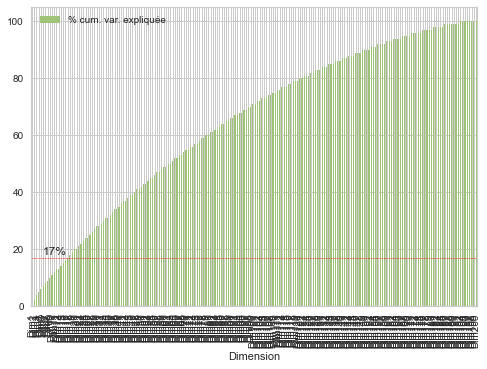

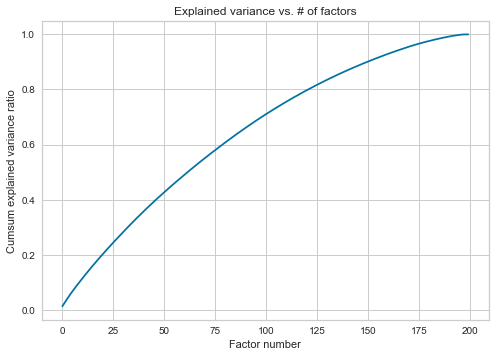

In [183]:
pk_multi.amulti_acp_choice_dim(mod_cbow, Z)

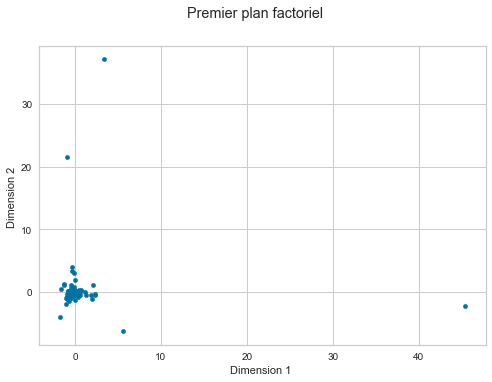

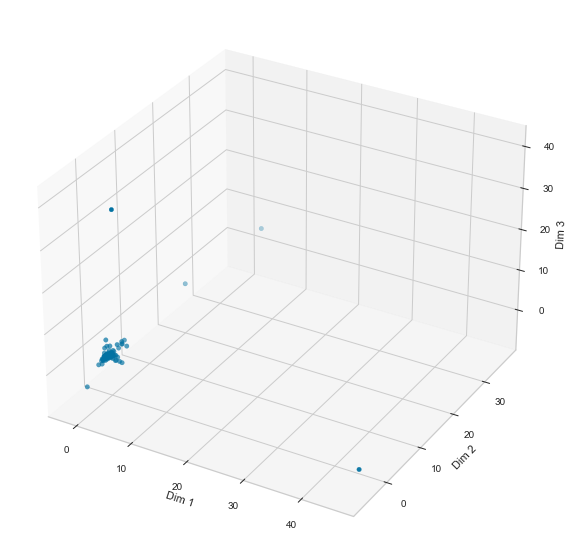

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [184]:
#pk.amultiacp_visualizer(df_acp2, Z, 3, df_acp,df_acp["customer_unique_id"], df_acp["order_id_size"], "order_id_size")
pk_multi.amultiacp_visualizer(mod_cbow, Z, 3, reviews, reviews["words_subjects"], reviews.index, "TF-IDF")

ACP TF-IDF

In [168]:
mod_tfidf = tfIdf.toarray()

In [171]:
Z = pk_multi.amulti_acp_standard(mod_tfidf)

200
[1.29416289e+01 1.16114515e+01 1.00960430e+01 9.98772411e+00
 9.92127897e+00 9.80232380e+00 9.70911357e+00 9.67548274e+00
 9.59391300e+00 9.40781971e+00 9.29201797e+00 9.20557843e+00
 9.05531925e+00 8.93319259e+00 8.83267779e+00 8.81317456e+00
 8.76603684e+00 8.66048728e+00 8.61657841e+00 8.56226287e+00
 8.45943322e+00 8.39199674e+00 8.35637922e+00 8.26725034e+00
 8.17236933e+00 8.15421498e+00 8.09315484e+00 8.07655324e+00
 7.98915071e+00 7.87600197e+00 7.82510049e+00 7.81961909e+00
 7.75186583e+00 7.68724287e+00 7.65816642e+00 7.65286580e+00
 7.63920595e+00 7.58664858e+00 7.54873034e+00 7.46458713e+00
 7.37733230e+00 7.34529941e+00 7.30616636e+00 7.25716844e+00
 7.19426614e+00 7.15588952e+00 7.13974327e+00 7.04668337e+00
 7.00029441e+00 6.96529244e+00 6.91378235e+00 6.88674598e+00
 6.83287586e+00 6.80065763e+00 6.78703559e+00 6.69631946e+00
 6.66245540e+00 6.61967972e+00 6.58872493e+00 6.55825965e+00
 6.52454729e+00 6.48937775e+00 6.46620873e+00 6.41793453e+00
 6.40211955e+00 6.33

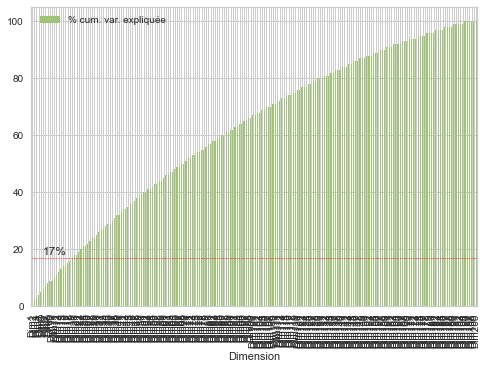

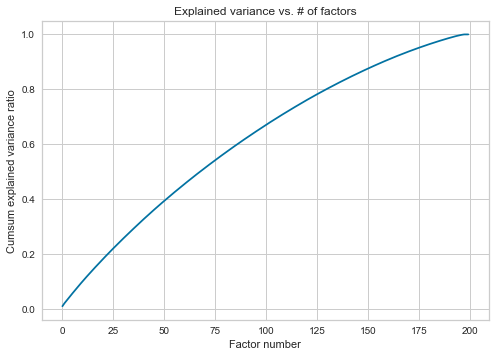

In [173]:
pk_multi.amulti_acp_choice_dim(mod_tfidf, Z)

In [176]:
mod_tfidf.shape

(200, 1079)

In [177]:
reviews

,rw_id,rw_rating,rw_text,nb_words,words,new_words,stemmed,words_ok,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,feeling_pos,feeling_avg,card2vec,use,tsnec2v,tsneuse,tfidf,tsnetfidf
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","['', 'favorite', 'meal', '', '', '', 'started'...","[""''""'favorit''meal'""''""""''""""''""'start''off'""'...",favorit meal start off foie gras carpaccio esc...,"[(favorit, NN), (meal, JJ), (start, VB), (off,...","favorit meal meal,foie gras gras,prepar prepar",0.000,0.781,0.219,Positive,"[-0.004791805520653725, -0.007672524079680443,...","[0.043498240411281586, -0.022697744891047478, ...","[12.873913764953613, 14.860135078430176]","[4.006133079528809, 3.9473185539245605]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-251.38890075683594, -128.5460968017578]"
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran...","['', 'is', '', 'small', 'bar', 'restaurant', '...","[""''""'is'""''""'small''bar''restaur''close'""''""'...",is small bar restaur close cathédral notr dame...,"[(is, VBZ), (small, JJ), (bar, NN), (restaur, ...","small bar restaur restaur,cathédral notr dame ...",0.000,0.833,0.167,Positive,"[-0.02035706862807274, -0.027446474879980087, ...","[-0.006249221973121166, -0.03621714934706688, ...","[3.332287311553955, 1.7332254648208618]","[1.2726678848266602, -3.071220636367798]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-158.5586700439453, 102.99634552001953]"
2,U8G3f8ITSlqBzETBDVO8bw,5.0,"foods were delicious, great ambiance, and help...",24.0,"['foods', 'were', 'delicious', 'great', 'ambia...","['foods', 'were', 'delicious', 'great', 'ambia...","[""''food""'were''delici''great''ambianc'""''""'he...",food were delici great ambianc help staff riso...,"[(food, NN), (were, VBD), (delici, JJ), (great...","food food,delici great ambianc help staff staf...",0.000,0.536,0.464,Positive,"[-0.00888708233833313, -0.029408633708953857, ...","[-0.02060977928340435, 0.028547946363687515, -...","[7.4197187423706055, 8.130528450012207]","[-0.5197389125823975, -1.8103233575820923]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-161.90196228027344, -44.327919006347656]"
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ...",25.0,"['this', 'is', 'for', 'a', 'review', 'from', '...","['', 'is', '', '', 'review', '', '2019', '', '...","[""''""'is'""''""""''""'review'""''""'2019'""''""'place'...",is review place is perfect would recommend pri...,"[(is, VBZ), (review, JJ), (place, NN), (is, VB...","review place place,price price,great food food...",0.000,0.480,0.520,Positive,"[-0.00959128886461258, -0.01883460208773613, -...","[-0.05699789151549339, 0.03655901551246643, 0....","[9.092153549194336, 9.868383407592773]","[-8.60776138305664, 2.185488700866699]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-102.2981185913086, -193.76519775390625]"
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred. reservations weeks in advanc...,23.0,"['michelin', 'starred', 'reservations', 'weeks...","['michelin', 'starred', 'reservations', 'weeks...","[""''michelin""'star''reserv''week'""''""'advanc''...",michelin star reserv week advanc is absolut ne...,"[(michelin, NN), (star, NN), (reserv, NN), (we...","michelin star reserv week advanc advanc,second...",0.000,0.857,0.143,Positive,"[-0.01665910892188549, -0.02317342907190323, -...","[0.02894892543554306, -0.12255124747753143, 0....","[3.625493288040161, 3.9331488609313965]","[-11.363548278808594, 5.6826300621032715]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.326...","[202.86322021484375, -148.70391845703125]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,"paris, france\n\nhangry? \n\nwhen the most pop...",27.0,"['paris', 'france', 'hangry', 'when', 'the', '...","['', 'france'

In [179]:
Z.shape

(200, 1079)

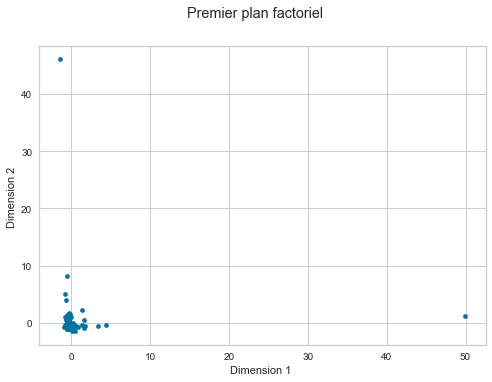

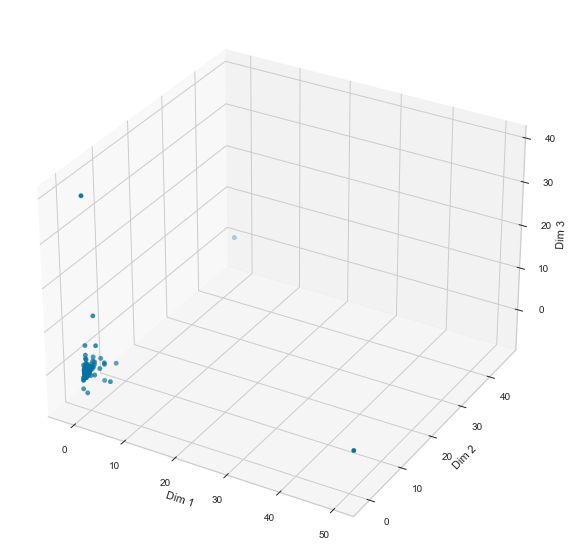

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [180]:
#pk.amultiacp_visualizer(df_acp2, Z, 3, df_acp,df_acp["customer_unique_id"], df_acp["order_id_size"], "order_id_size")
pk_multi.amultiacp_visualizer(mod_tfidf, Z, 3, reviews, reviews["words_subjects"], reviews.index, "TF-IDF")

In [48]:
mat_words_subjects.index

Index(['gras', 'prepar', 'meal', 'foie', 'favorit', 'pie', 'pedra', 'pig',
       'parisian', 'parmenti',
       ...
       'fancier', 'fantast', 'fast', 'fat', 'fattoush', 'feet', 'felix',
       'fellow', 'femal', 'île'],
      dtype='object', length=864)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 864 samples in 0.000s...
[t-SNE] Computed neighbors for 864 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 864 / 864
[t-SNE] Mean sigma: 1.817002
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.661049
[t-SNE] KL divergence after 300 iterations: 0.194212


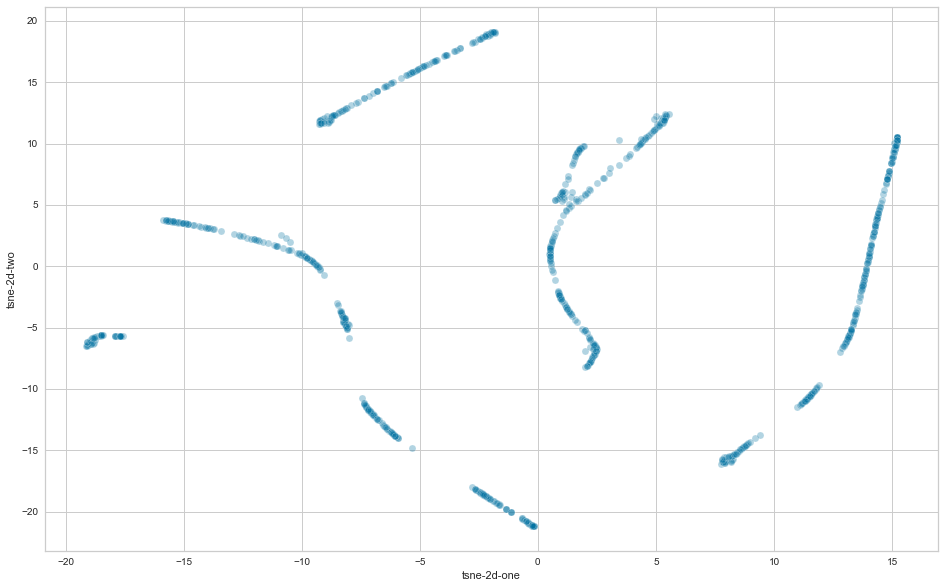

In [54]:
pk_multi.tsne_graph(mat_words_subjects, group=0, by="")



In [55]:
pk_multi.umap_graphs(mat_words_subjects)

In [70]:
mat_words_subjects.head(6)

,TF-IDF
gras,0.632181
prepar,0.570135
meal,0.384774
foie,0.285067
favorit,0.214427
pie,0.000000


In [185]:
gc.collect()

78861